In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

!pip install lime
from lime.lime_tabular import LimeTabularExplainer

In [12]:
df = pd.read_csv('/content/Laptop_Price_Prediction.csv')

In [13]:
df["Final Price"]

,Final Price
0,1009.00
1,299.00
2,789.00
3,1199.00
4,669.01
...,...
2155,2699.99
2156,2899.99
2157,3399.99
2158,1899.99


In [14]:
df.shape

(2160, 12)

In [15]:
df.sample(5)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
1191,Lenovo ThinkPad T490 Intel Core i7-8565U/16GB/...,Refurbished,Lenovo,ThinkPad,Intel Core i7,16,512,SSD,NaN,14.0,No,794.99
1217,ASUS ExpertBook B5 B5402CBA-EB0316X Intel Core...,New,Asus,ExpertBook,Intel Core i5,16,512,SSD,NaN,14.0,No,1259.00
1691,ASUS ROG Zephyrus Duo 16 GX650RX-LO162W AMD Ry...,Refurbished,Asus,ROG,AMD Ryzen 9,64,4000,SSD,RTX 3080,16.0,No,3999.00
1301,Asus TUF Gaming A15 FA507RR AMD Ryzen 7 6800H/...,New,Asus,TUF,AMD Ryzen 7,16,512,SSD,RTX 3070,15.6,No,1454.12
202,ASUS VivoBook F1500EA-BQ2649W Intel Core i3-11...,New,Asus,VivoBook,Intel Core i3,8,512,SSD,NaN,15.6,No,499.00


In [16]:
df["Brand"].unique()

array(['Asus', 'Alurin', 'MSI', 'HP', 'Lenovo', 'Medion', 'Acer', 'Apple',
       'Razer', 'Gigabyte', 'Dell', 'LG', 'Samsung', 'PcCom', 'Microsoft',
       'Primux', 'Prixton', 'Dynabook Toshiba', 'Thomson', 'Denver',
       'Deep Gaming', 'Vant', 'Innjoo', 'Jetwing', 'Millenium', 'Realme',
       'Toshiba'], dtype=object)

In [17]:
df['CPU'].unique()

array(['Intel Core i5', 'Intel Celeron', 'Intel Core i3', 'Intel Core i7',
       'AMD Ryzen 5', 'AMD Ryzen 7', 'AMD Ryzen 3', 'Apple M1',
       'AMD Athlon', 'Apple M2', 'AMD Ryzen 9', 'Intel Core i9',
       'AMD 3020e', 'Qualcomm Snapdragon 7', 'Intel Evo Core i7',
       'Intel Evo Core i5', 'Intel Pentium', 'Apple M2 Pro',
       'AMD Radeon 5', 'Intel Evo Core i9', 'AMD 3015e', 'Apple M1 Pro',
       'Intel Core M3', 'AMD Radeon 9', 'Mediatek MT8183', 'AMD 3015Ce',
       'Qualcomm Snapdragon 8', 'Microsoft SQ1'], dtype=object)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


In [19]:
df.dtypes

,0
Laptop,object
Status,object
Brand,object
Model,object
CPU,object
RAM,int64
Storage,int64
Storage type,object
GPU,object
Screen,float64


In [20]:
df.duplicated().sum()

np.int64(0)

In [21]:
df.isnull().sum()

,0
Laptop,0
Status,0
Brand,0
Model,0
CPU,0
RAM,0
Storage,0
Storage type,42
GPU,1371
Screen,4


In [22]:
# model: have unwanted data so, we need to clean
# cpu: also have some messy data,
# Storgae also need to clean
#Storage type have null value
# GPU: have null value and also messy data
# screen: have null vlaue and also minor do preprocessing
# touch is clean just do as yes-1 and NO-0
# Final price : minor scaling


Cleaning

# Convert to string and clean text columns by removing extra quotes and spaces
# This ensures consistent categorical values and avoids duplicates during EDA and modeling

<Axes: xlabel='Final Price', ylabel='Density'>

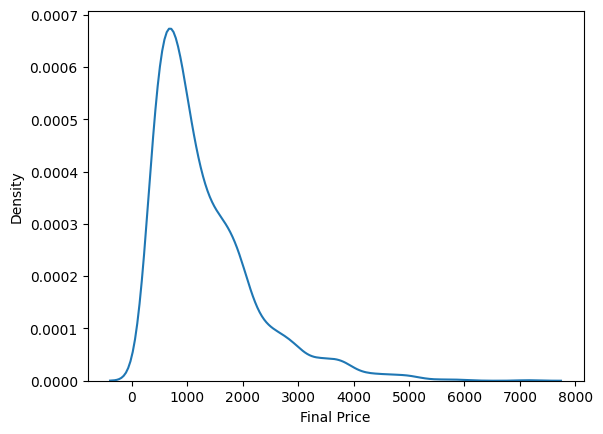

In [23]:
sns.kdeplot(df['Final Price'])

In [24]:
df['Model'].astype(str).str.strip()

,Model
0,ExpertBook
1,Go
2,ExpertBook
3,Katana
4,15S
...,...
2155,Blade
2156,Blade
2157,Blade
2158,Book


In [25]:
df['Brand'].astype(str).str.strip()

,Brand
0,Asus
1,Alurin
2,Asus
3,MSI
4,HP
...,...
2155,Razer
2156,Razer
2157,Razer
2158,Razer


In [26]:
df['RAM'] = pd.to_numeric(df['RAM'], errors='coerce')
df['Storage'] = pd.to_numeric(df['Storage'], errors='coerce')

# Convert RAM and Storage to numeric; invalid entries become NaN for proper analysis


*   Ensures columns are usable for EDA & ML
*   Handles bad values like "8GB", "unknown", " " safely


*   Handles bad values like "8GB", "unknown", " " safely
*   Allows you to fill NaN with median later







Any non-numeric or missing values in Screen are replaced with the column median.

In [27]:
df['Screen'] = pd.to_numeric(df['Screen'], errors='coerce')
df['Screen'].fillna(df['Screen'].median(), inplace=True)

/tmp/ipython-input-2244641484.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Screen'].fillna(df['Screen'].median(), inplace=True)




*   Removes extra spaces in the column.

*   Maps 'Yes' → 1 and 'No' → 0.
*   Converts the column to integer type.






In [28]:
df['Touch'] = df['Touch'].str.strip().map({'Yes': 1, 'No': 0})
df['Touch'] = df['Touch'].astype(int)

In [29]:
df['Storage type'].fillna('SSD', inplace=True)

/tmp/ipython-input-21381583.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Storage type'].fillna('SSD', inplace=True)


*   Looks for any missing values (NaN) in the column.
*   Replaces them with 'SSD' (assuming SSD is the default or most common storage type).

In [30]:
df['GPU'].fillna('None', inplace=True)
df['GPU'] = df['GPU'].str.strip()


/tmp/ipython-input-3116940090.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GPU'].fillna('None', inplace=True)




*  No missing values in GPU.

*   Clean strings with no extra spaces.








In [31]:
df['GPU'] = df['GPU'].str.replace(r'\s+', '', regex=True)
df['CPU'] = df['CPU'].str.strip()
df['CPU'] = df['CPU'].str.replace(r'\s+', ' ', regex=True)

GPU: All extra spaces removed, compact format for easier processing/encoding.

CPU: Leading/trailing spaces removed, multiple internal spaces replaced with a single space for consistent formatting.

In [32]:
df.isnull().sum()

,0
Laptop,0
Status,0
Brand,0
Model,0
CPU,0
RAM,0
Storage,0
Storage type,0
GPU,0
Screen,0


In [33]:
df.drop(columns=['Laptop'], inplace=True)

In [34]:
df.head()

,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,None,15.6,0,1009.00
1,New,Alurin,Go,Intel Celeron,8,256,SSD,None,15.6,0,299.00
2,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,None,15.6,0,789.00
3,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX3050,15.6,0,1199.00
4,New,HP,15S,Intel Core i5,16,512,SSD,None,15.6,0,669.01


In [35]:
df.to_csv('Cleaned Laptop.csv')

EDA

/tmp/ipython-input-2393136421.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Final Price'])


<Axes: xlabel='Final Price', ylabel='Density'>

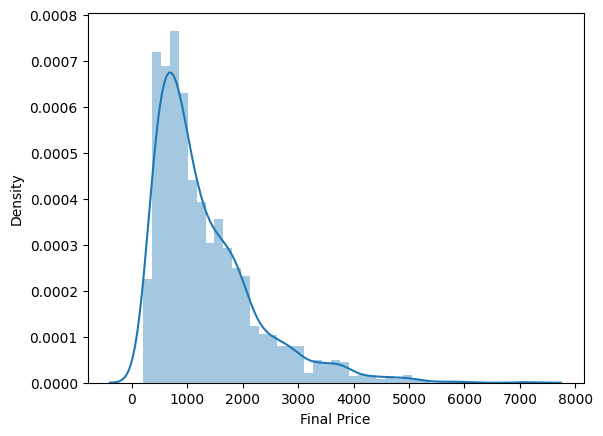

In [36]:
sns.distplot(df['Final Price'])

<Axes: xlabel='Brand'>

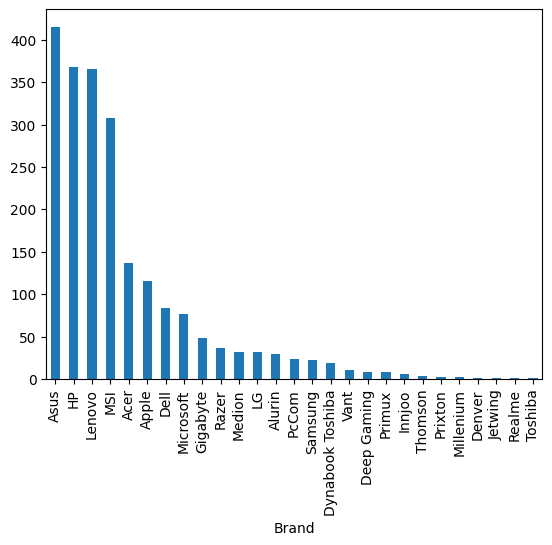

In [37]:
df['Brand'].value_counts().plot(kind='bar')

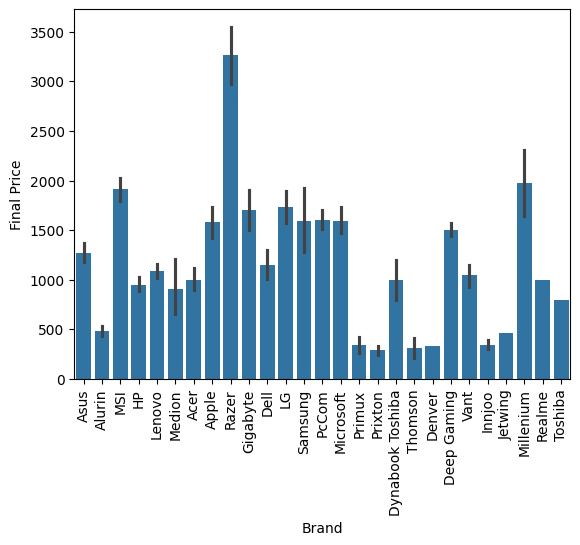

In [38]:
sns.barplot(x=df['Brand'], y=df['Final Price'])
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Status'>

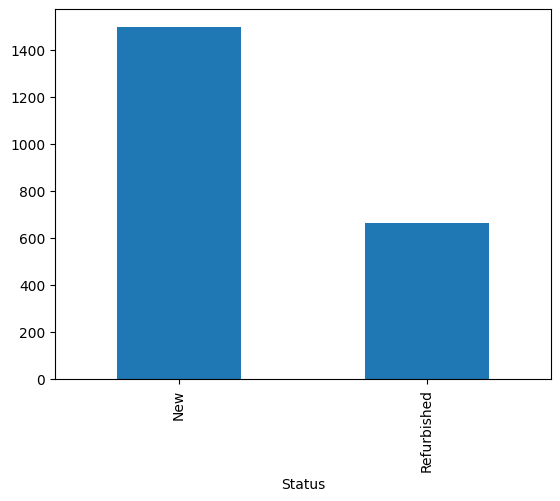

In [39]:
df['Status'].value_counts().plot(kind='bar')

<Axes: xlabel='Storage type'>

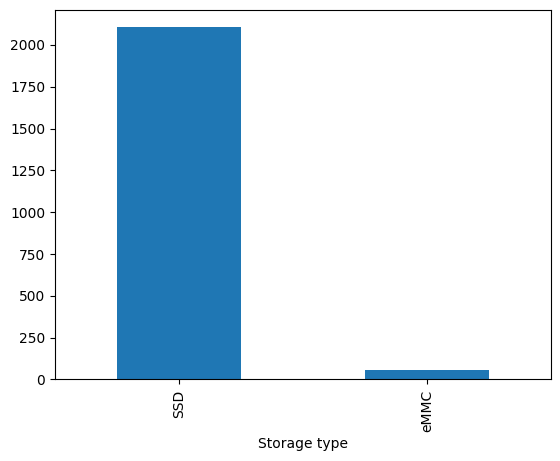

In [40]:
df['Storage type'].value_counts().plot(kind='bar')


<Axes: xlabel='Touch'>

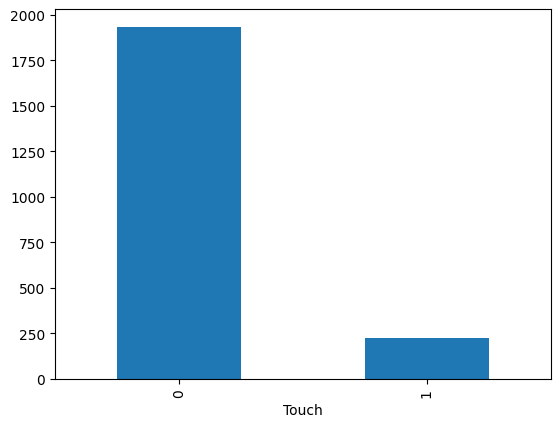

In [41]:
df['Touch'].value_counts().plot(kind='bar')

<function matplotlib.pyplot.show(close=None, block=None)>

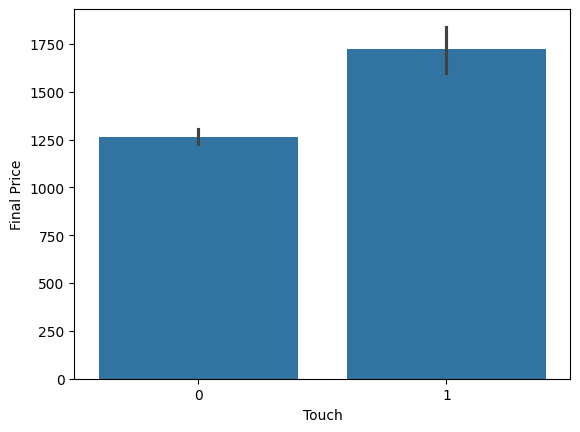

In [42]:
sns.barplot(x=df['Touch'], y=df['Final Price'])
plt.show

In [43]:
df['CPU'].value_counts()

,count
CPU,
Intel Core i7,710
Intel Core i5,535
AMD Ryzen 7,156
Intel Core i3,130
AMD Ryzen 5,127
Intel Celeron,94
Intel Core i9,94
Intel Evo Core i7,82
AMD Ryzen 9,44


In [44]:
def cpu_tier(cpu):
    if any(x in cpu for x in ['i9','Ryzen 9','M2 Pro','M1 Pro']): return 5
    if any(x in cpu for x in ['i7','Ryzen 7','M2','M1']): return 4
    if any(x in cpu for x in ['i5','Ryzen 5']): return 3
    if any(x in cpu for x in ['i3','Ryzen 3','Athlon']): return 2
    if any(x in cpu for x in ['Celeron','Pentium','3020e','3015e']): return 1
    return 2

df['CPU_Tier'] = df['CPU'].astype(str).apply(cpu_tier)


Instead of complex parsing, I engineered ordinal CPU and GPU tiers based on performance levels. This reduced dimensionality and captured hardware capability effectively.”

In [45]:
df.drop(columns=['CPU'], inplace=True)


<Axes: xlabel='CPU_Tier'>

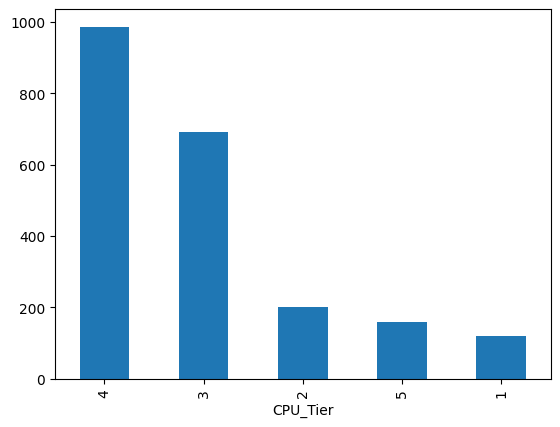

In [46]:
df['CPU_Tier'].value_counts().plot(kind='bar')

<Axes: xlabel='RAM'>

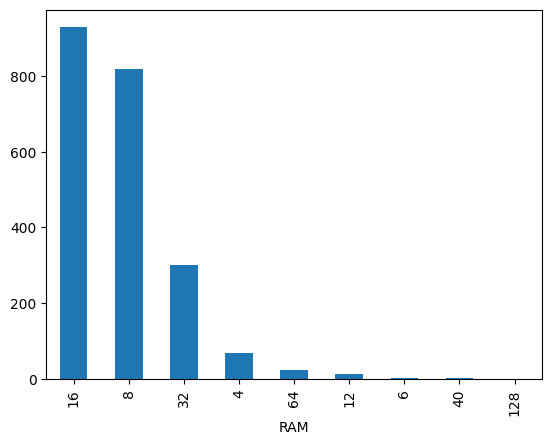

In [47]:
df['RAM'].value_counts().plot(kind='bar')

In [48]:
df['GPU'].value_counts()

,count
GPU,
None,1371
RTX3050,129
RTX3060,122
RTX3070,97
RTX4060,62
RTX3080,51
GTX1650,50
RTX4070,40
RTX4050,33


In [49]:
df['gpu_brand'] = df['GPU'].apply(
    lambda x: 'NVIDIA' if 'RTX' in x or 'GTX' in x or 'MX' in x
    else 'AMD' if 'RX' in x or 'Radeon' in x
    else 'Unknown'
)


In [50]:
def gpu_power(x):
    if 'RTX' in x: return 3
    elif 'GTX' in x: return 2
    elif 'MX' in x: return 1
    else: return 0

df['gpu_power'] = df['GPU'].apply(gpu_power)


In [51]:
df = pd.get_dummies(df, columns=['gpu_brand'], drop_first=True)
df.drop('GPU', axis=1, inplace=True)


<Axes: xlabel='gpu_power'>

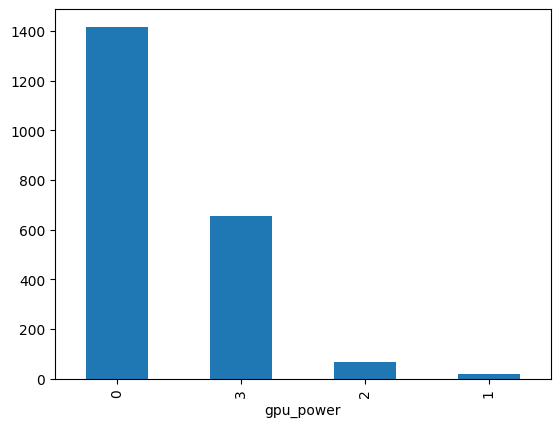

In [52]:
df['gpu_power'].value_counts().plot(kind='bar')

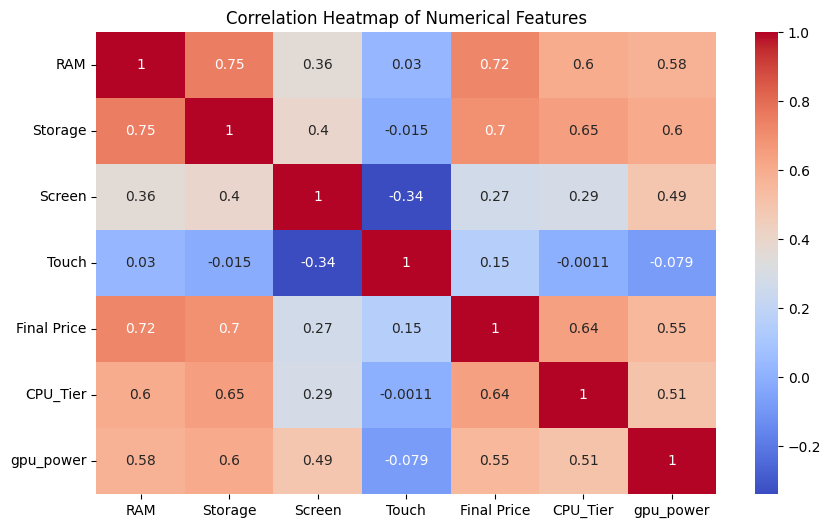

In [53]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [54]:
df.head(3)

,Status,Brand,Model,RAM,Storage,Storage type,Screen,Touch,Final Price,CPU_Tier,gpu_power,gpu_brand_NVIDIA,gpu_brand_Unknown
0,New,Asus,ExpertBook,8,512,SSD,15.6,0,1009.0,3,0,False,True
1,New,Alurin,Go,8,256,SSD,15.6,0,299.0,1,0,False,True
2,New,Asus,ExpertBook,8,256,SSD,15.6,0,789.0,2,0,False,True


/tmp/ipython-input-3897261032.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['Final Price']))


<Axes: xlabel='Final Price', ylabel='Density'>

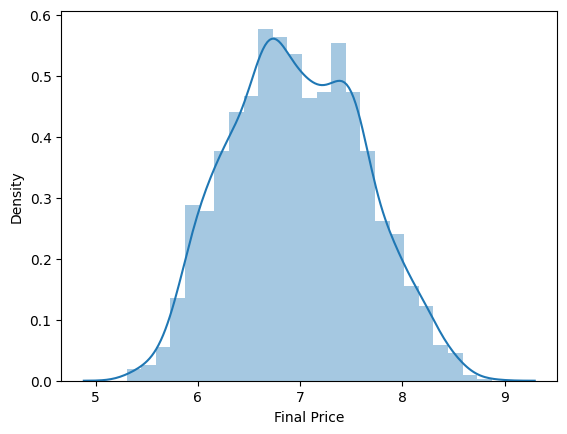

In [55]:
sns.distplot(np.log(df['Final Price']))

Skewed targets can cause:

Poor predictions

Large errors for expensive items

Model focusing too much on high values

np.log() does:

Compresses large values

Spreads smaller values

Makes distribution more symmetric / normal

In [56]:
x = df.drop(columns=['Final Price'])
y = np.log(df['Final Price'])

In [57]:
x

,Status,Brand,Model,RAM,Storage,Storage type,Screen,Touch,CPU_Tier,gpu_power,gpu_brand_NVIDIA,gpu_brand_Unknown
0,New,Asus,ExpertBook,8,512,SSD,15.6,0,3,0,False,True
1,New,Alurin,Go,8,256,SSD,15.6,0,1,0,False,True
2,New,Asus,ExpertBook,8,256,SSD,15.6,0,2,0,False,True
3,New,MSI,Katana,16,1000,SSD,15.6,0,4,3,True,False
4,New,HP,15S,16,512,SSD,15.6,0,3,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,Refurbished,Razer,Blade,16,1000,SSD,17.3,0,4,3,True,False
2156,Refurbished,Razer,Blade,16,1000,SSD,17.3,0,4,3,True,False
2157,Refurbished,Razer,Blade,32,1000,SSD,17.3,0,4,3,True,False
2158,Refurbished,Razer,Book,16,1000,SSD,13.4,1,4,0,False,True


Because it is the target

Model should NOT see the answer during training (data leakage)

Laptop prices are:

Right-skewed

Have extreme high values (outliers)

Log transform:

Reduces skewness

Makes errors more uniform

Helps linear models learn better

 Important:

We transform the target, not the features

In [58]:
y

,Final Price
0,6.916715
1,5.700444
2,6.670766
3,7.089243
4,6.505799
...,...
2155,7.901003
2156,7.972463
2157,8.131528
2158,7.549604


In [59]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=2)

We split the dataset into training and testing sets to evaluate how well the model generalizes to unseen data, using a fixed random_state for reproducibility.

In [60]:
X_train

,Status,Brand,Model,RAM,Storage,Storage type,Screen,Touch,CPU_Tier,gpu_power,gpu_brand_NVIDIA,gpu_brand_Unknown
1638,New,Microsoft,Surface Laptop,8,512,SSD,15.0,1,4,0,False,True
744,New,Acer,Extensa,16,512,SSD,15.6,0,3,0,False,True
1623,New,Microsoft,Surface Laptop,8,512,SSD,13.5,1,3,0,False,True
2102,Refurbished,MSI,Pulse,16,1000,SSD,17.3,0,4,3,True,False
1636,New,Microsoft,Surface Laptop,16,256,SSD,15.0,1,4,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1071,Refurbished,HP,ProBook,8,256,SSD,13.3,0,3,0,False,True
433,New,LG,Gram,32,512,SSD,17.0,0,4,0,False,True
674,New,Lenovo,V15,16,512,SSD,15.6,0,4,0,False,True
1099,New,MSI,Raider,32,2000,SSD,17.0,0,5,3,True,False


In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore",
                min_frequency=20,
                sparse_output=False
            ),
            ["Status", "Brand", "Model", "Storage type"]
        ),
        (
            "num",
            StandardScaler(),
            ["RAM", "Storage", "Screen","Touch", "CPU_Tier", "gpu_power","gpu_brand_NVIDIA","gpu_brand_Unknown"]
        )
    ]
)


We use ColumnTransformer to apply different preprocessing steps to different columns in a dataset, especially when working with mixed data types, while preventing data leakage and ensuring consistency between training and testing data.

Model

Ridge Regression

In [62]:
ridge_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', Ridge())
])

param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_cv = GridSearchCV(
    ridge_pipe,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

ridge_cv.fit(X_train, y_train)

print("Best alpha:", ridge_cv.best_params_)
print("Best CV R2:", ridge_cv.best_score_)

best_model = ridge_cv.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

Best alpha: {'model__alpha': 1}
Best CV R2: 0.8052521716250695


In [63]:
print('R2 score for test:', r2_score(y_test, y_pred_test) * 100)
print('MAE for test:', mean_absolute_error(y_test, y_pred_test))

print('---------------------------')

print('R2 score for train:', r2_score(y_train, y_pred_train) * 100)
print('MAE for train:', mean_absolute_error(y_train, y_pred_train))

R2 score for test: 81.41958881024722
MAE for test: 0.2171897241361157
---------------------------
R2 score for train: 82.898910407969
MAE for train: 0.20178782469017711


I used a pipeline with Ridge Regression to ensure consistent preprocessing and avoid data leakage. GridSearchCV was applied to tune the regularization parameter alpha using 5-fold cross-validation, and the best model was evaluated on unseen test data using R².

A Pipeline ensures that preprocessing and model training happen in the correct order, consistently, and without data leakage.

Linear Regression was not used because it lacks regularization and hyperparameter control, making it less robust than Ridge Regression for reliable prediction.

This parameter grid allows GridSearchCV to tune the Ridge Regression regularization strength by evaluating multiple alpha values.

GridSearchCV is used to tune Ridge Regression’s alpha by testing multiple values with 5-fold cross-validation and selecting the one with the highest R² score.

Random Forest

In [64]:
rf_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


param_grid = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [10, 12, 15],
    'model__min_samples_split': [10, 15, 20],
    'model__min_samples_leaf': [2, 3, 5],
    'model__max_features': ['sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train, y_train)

print("Best hyperparameters:", rf_random.best_params_)
print("Best CV R2 score:", rf_random.best_score_)


best_rf = rf_random.best_estimator_

y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 3, 'model__max_features': 'sqrt', 'model__max_depth': 15}
Best CV R2 score: 0.8163582544200793


In [65]:
print('R2 score for train:', r2_score(y_train, y_pred_train) * 100)
print('MAE for train:', mean_absolute_error(y_train, y_pred_train))
print("---------")
print('R2 score for test:', r2_score(y_test, y_pred_test) * 100)
print('MAE for test:', mean_absolute_error(y_test, y_pred_test))

R2 score for train: 84.9380106534316
MAE for train: 0.19162855216270713
---------
R2 score for test: 81.94696905136193
MAE for test: 0.21596990182799725


Random Forest Regressor is an ensemble learning model

It combines multiple decision trees and averages their predictions

This improves accuracy and reduces overfitting

I built a preprocessing and Random Forest regression pipeline, optimized its hyperparameters using RandomizedSearchCV with 5-fold cross-validation, selected the best model based on R² score, and finally evaluated its performance on both training and test datasets.

XGBoost

In [66]:
xgb_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.8, 1],
    'model__colsample_bytree': [0.7, 0.8, 1],
    'model__gamma': [0, 0.1, 0.2],
    'model__min_child_weight': [1, 2, 5]
}


xgb_cv = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)



In [67]:
xgb_cv.fit(X_train, y_train)
print("Best hyperparameters:", xgb_cv.best_params_)
print("Best CV R2 score:", xgb_cv.best_score_)

best_xgb = xgb_cv.best_estimator_
y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)


print('R2 score for train:', r2_score(y_train, y_pred_train)*100)
print('MAE for train:', mean_absolute_error(y_train, y_pred_train))
print("--------------------")
print('R2 score for test:', r2_score(y_test, y_pred_test)*100)
print('MAE for test:', mean_absolute_error(y_test, y_pred_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__subsample': 0.7, 'model__n_estimators': 100, 'model__min_child_weight': 1, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.8}
Best CV R2 score: 0.8463862510257549
R2 score for train: 89.32056504577181
MAE for train: 0.15733443264605443
--------------------
R2 score for test: 84.97722371360344
MAE for test: 0.1933592469933197


I implemented an XGBoost regression pipeline with preprocessing, optimized its hyperparameters using RandomizedSearchCV with 5-fold cross-validation, selected the best model based on R² score, and evaluated its performance using R² and MAE on both training and test datasets to ensure good generalization.

StackingRegressor

In [68]:
# Define Base Model
ridge_model = Ridge(alpha=1.0, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.8,
    gamma=0,
    random_state=42
)

# Define Stacking Model

stack_model = StackingRegressor(
    estimators=[
        ('ridge', ridge_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=Ridge(),
    cv=5,
    n_jobs=-1
)

stack_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', stack_model)
])

In [69]:
stack_pipe.fit(X_train, y_train)

y_pred_train = stack_pipe.predict(X_train)
y_pred_test = stack_pipe.predict(X_test)

print("Stack Train R2:", r2_score(y_train, y_pred_train)*100)
print("Stack Test R2:", r2_score(y_test, y_pred_test)*100)
print("Stack Test MAE:", mean_absolute_error(y_test, y_pred_test))

Stack Train R2: 88.88205016112992
Stack Test R2: 85.11034914791288
Stack Test MAE: 0.19315419997044253


Ridge Regression is a linear regression model with L2 regularization.

It helps reduce multicollinearity and prevents overfitting.

alpha=1.0 controls the strength of regularization.

This model captures linear relationships in the data.

Random Forest is an ensemble of decision trees using bagging.

It captures non-linear relationships and feature interactions.

The hyperparameters are already tuned to balance bias and variance.

It is robust to outliers and overfitting compared to a single tree.

XGBoost is a gradient boosting algorithm.

Trees are built sequentially, correcting previous errors.

It provides strong performance for complex, non-linear patterns.

Regularization and subsampling help control overfitting.

Ridge → captures linear trends

Random Forest → captures non-linear patterns

XGBoost → captures complex boosted interactions

Because stacking combines the strengths of multiple diverse models, leading to better generalization and more stable performance.

LIME explainer

In [70]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names_after_preprocessing = preprocessor.get_feature_names_out()

explainer = LimeTabularExplainer(
    training_data=X_train_processed,
    feature_names=feature_names_after_preprocessing,
    mode='regression',
    discretize_continuous=True
)


i = 0
predict_function_for_lime = stack_pipe.named_steps['model'].predict

explanation = explainer.explain_instance(
    data_row=X_test_processed[i],
    predict_fn=predict_function_for_lime,
    num_features=10
)
explanation.show_in_notebook(show_table=True)

print(explanation.as_list())

[('num__RAM > 0.06', 0.638324492093169), ('cat__Model_EliteBook <= 0.00', -0.2747724123091633), ('cat__Brand_Dell <= 0.00', -0.23645154683608346), ('cat__Model_ThinkPad <= 0.00', -0.2150183152889664), ('-0.42 < num__CPU_Tier <= 0.63', 0.20474247839671786), ('cat__Brand_Microsoft <= 0.00', -0.19414589573829263), ('cat__Brand_Apple <= 0.00', -0.19242432957154104), ('-0.23 < num__Storage <= 1.14', 0.16964553868465498), ('cat__Model_V15 <= 0.00', 0.16477082757647496), ('cat__Brand_Alurin <= 0.00', 0.16377730919592923)]
